In [617]:
import numpy as np
import pandas as pd

import scipy.stats as st
from scipy.stats import skew
from math import sqrt
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
%matplotlib inline
sns.set()

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LassoLarsIC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import RegressorMixin
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', 
              lambda x: '{:.5f}'.format(x)) #Limiting floats output to 5 decimal points

In [618]:
def gauss_like(dframes, fitter):
    
    '''If shapiro statistic better after power transformation, 
       apply it to column, else just scale column'''
    
    num_cols = dframes[0].select_dtypes(include=[np.number]).columns
    changed_cols = []
    scaled_cols = []
    
    for col in num_cols:
        t = dframes[0][[col]].copy()
        shapiro_before = st.shapiro(dframes[0][col])[0]
        t = fitter[0].fit_transform(t)
        shapiro_after = st.shapiro(t)[0]
            
        if shapiro_before < shapiro_after:
            dframes[0][col] = t
            
            for df in dframes[1:]:
                df[[col]] = fitter[0].transform(df[[col]])
                
            changed_cols.append(col)
                
        else:
            dframes[0][[col]] = fitter[1].fit_transform(dframes[0][[col]])
            
            for df in dframes[1:]:
                df[[col]] = fitter[1].transform(df[[col]])
                
            scaled_cols.append(col)
    
    print('Transformed columns: ')
    print(*changed_cols, sep=', ')
    print('Scaled columns: ')
    print(*scaled_cols, sep=', ')
    
    return dframes


def cramers_v(confusion_matrix):
    
    ''' Calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328 '''
    
    chi2 = st.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    

def rmsle_cv(model, X, y):
    
    ''' cross_val_score with shuffled data before splitting. 
        Return Root-Mean-Squared-Error (RMSE) '''
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(X.values)
    
    rmse= np.sqrt(-cross_val_score(model, 
                                   X.values, 
                                   y, 
                                   scoring='neg_mean_squared_error', 
                                   cv = kf))
    return(rmse)

def write_to_submission_file(predicted_labels, out_file,
                             target='SalePrice', index_label="Id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1461, predicted_labels.shape[0] + 1461),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [1015]:
train = pd.read_csv('data/train.csv', index_col='Id')
test = pd.read_csv('data/test.csv', index_col='Id')

In [620]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.00000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.00000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.00000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.00000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.00000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Describe dataset

**Numerical columns**

In [621]:
numerical_columns = train.select_dtypes(include=[np.number]).columns.delete(-1)
numerical_columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [622]:
train[numerical_columns].describe()



,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.00000,1201.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1452.00000,1460.00000,1460.00000,...,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000,1460.00000
mean,56.89726,70.04996,10516.82808,6.09932,5.57534,1971.26781,1984.86575,103.68526,443.63973,46.54932,...,472.98014,94.24452,46.66027,21.95411,3.40959,15.06096,2.75890,43.48904,6.32192,2007.81575
std,42.30057,24.28475,9981.26493,1.38300,1.11280,30.20290,20.64541,181.06621,456.09809,161.31927,...,213.80484,125.33879,66.25603,61.11915,29.31733,55.75742,40.17731,496.12302,2.70363,1.32810
min,20.00000,21.00000,1300.00000,1.00000,1.00000,1872.00000,1950.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,2006.00000
25%,20.00000,59.00000,7553.50000,5.00000,5.00000,1954.00000,1967.00000,0.00000,0.00000,0.00000,...,334.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,2007.00000
50%,50.00000,69.00000,9478.50000,6.00000,5.00000,1973.00000,1994.00000,0.00000,383.50000,0.00000,...,480.00000,0.00000,25.00000,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,2008.00000
75%,70.00000,80.00000,11601.50000,7.00000,6.00000,2000.00000,2004.00000,166.00000,712.25000,0.00000,...,576.00000,168.00000,68.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.00000,2009.00000
max,190.00000,313.00000,215245.00000,10.00000,9.00000,2010.00000,2010.00000,1600.00000,5644.00000,1474.00000,...,1418.00000,857.00000,547.00000,552.00000,508.00000,480.00000,738.00000,15500.00000,12.00000,2010.00000


**Categorical columns**

In [623]:
categorical_columsns = train.select_dtypes(include=[np.object]).columns
categorical_columsns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [624]:
train[categorical_columsns].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [625]:
numerical_columns.size + categorical_columsns.size

79

**Visualising missing values for a sample of 250**

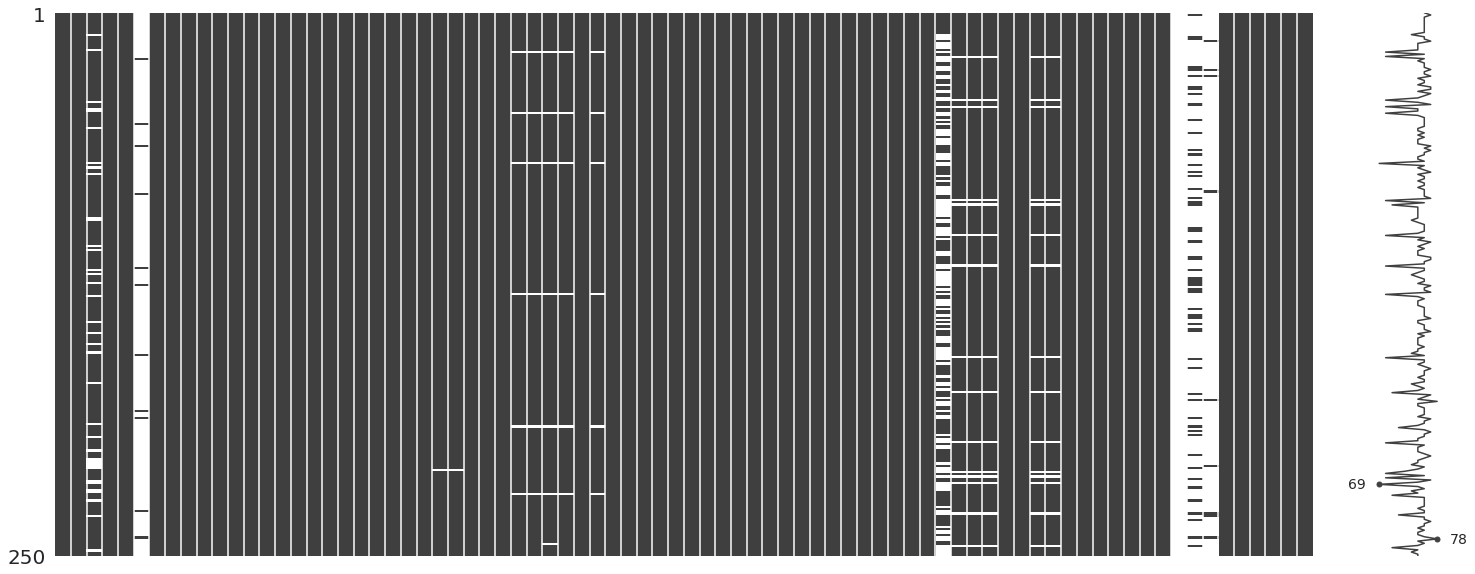

In [626]:
msno.matrix(train.sample(250));

**Nullity correlation: how strongly the presence or absence of one variable affects the presence of another**

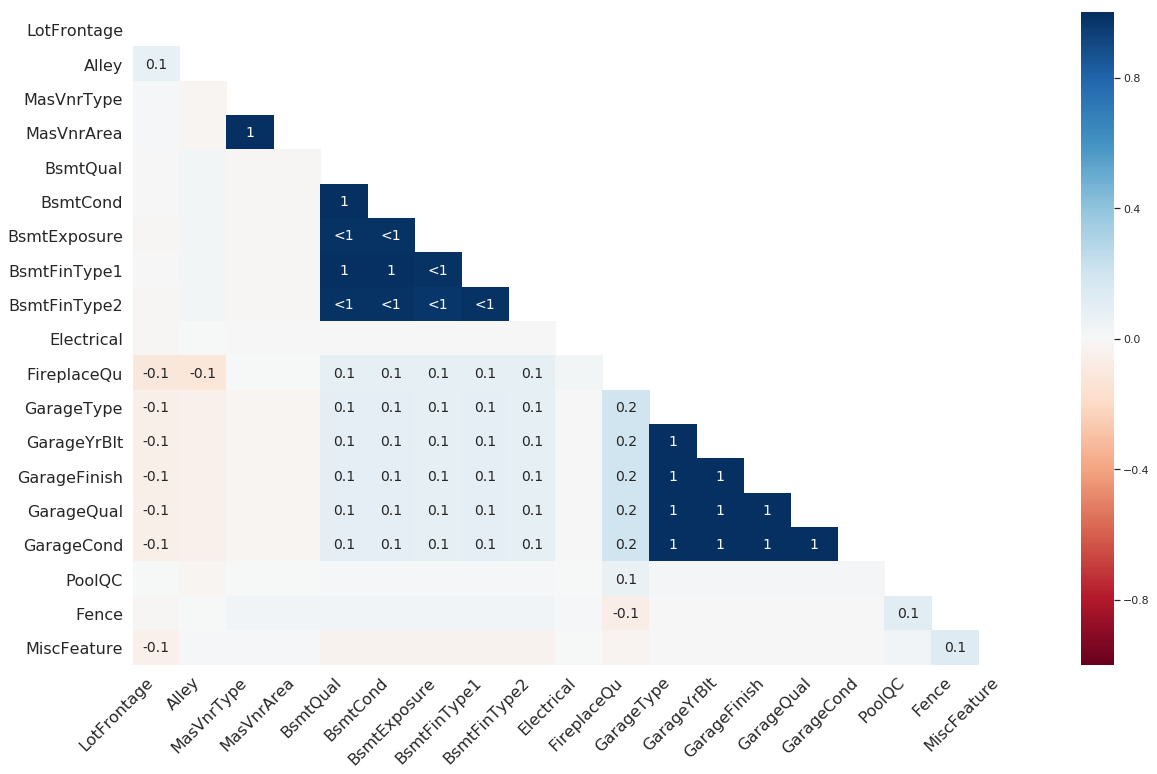

In [627]:
msno.heatmap(train);

**Plot missing values**

In [628]:
train_null = pd.DataFrame(train.isnull().sum()[train.isnull().sum() > 0].
                          sort_values(ascending=False), 
                          columns = ['missing'])

test_null = pd.DataFrame(test.isnull().sum()[test.isnull().sum() > 0].
                         sort_values(ascending=False), 
                         columns = ['missing'])



**Barchart: NaN in test and train**

In [629]:
trace1 = go.Bar(x = train_null.index, 
                y = train_null['missing'],
                name='train', 
                text = train_null.index)

trace2 = go.Bar(x = test_null.index, 
                y = test_null['missing'],
                name='test', 
                text = test_null.index)

data = [trace1, trace2]

layout = dict(title = 'NaN in test and train', 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = 'number of rows', side='left', ticklen=10),                                  
              legend=dict(orientation='v', x=1.05, y=1.0),
              autosize=True,
              barmode='group'
              )

fig = dict(data = data, layout = layout)
iplot(fig)

## Feature correlation

In [630]:
correlation = train.select_dtypes(include=[np.number]).corr()

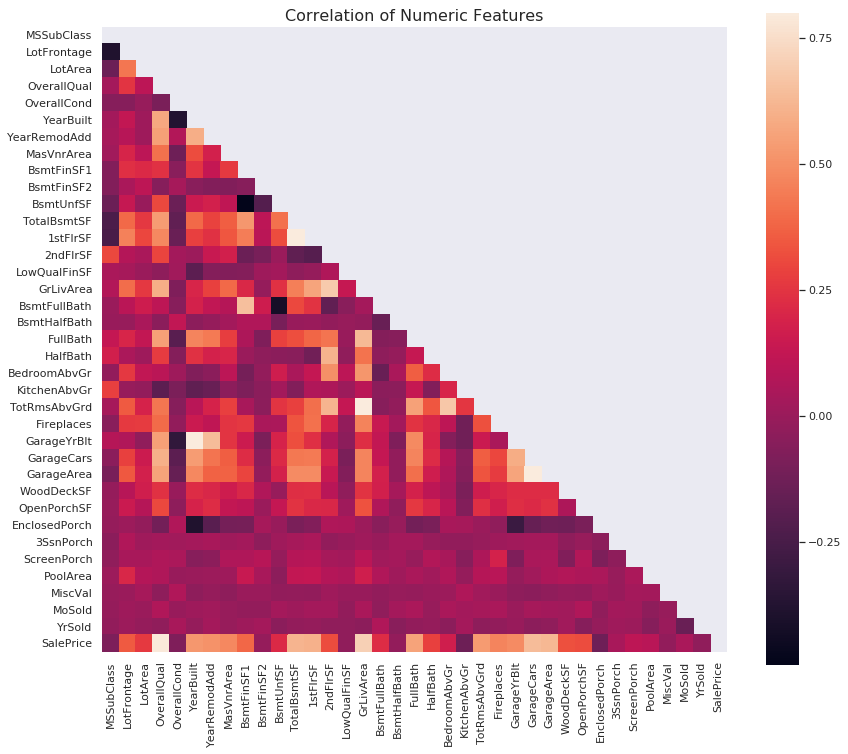

In [631]:
fig, axes = plt.subplots(figsize = (14, 12))

plt.title('Correlation of Numeric Features', size=16)

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    sns.heatmap(correlation, square = True, vmax=0.8, mask=mask);

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


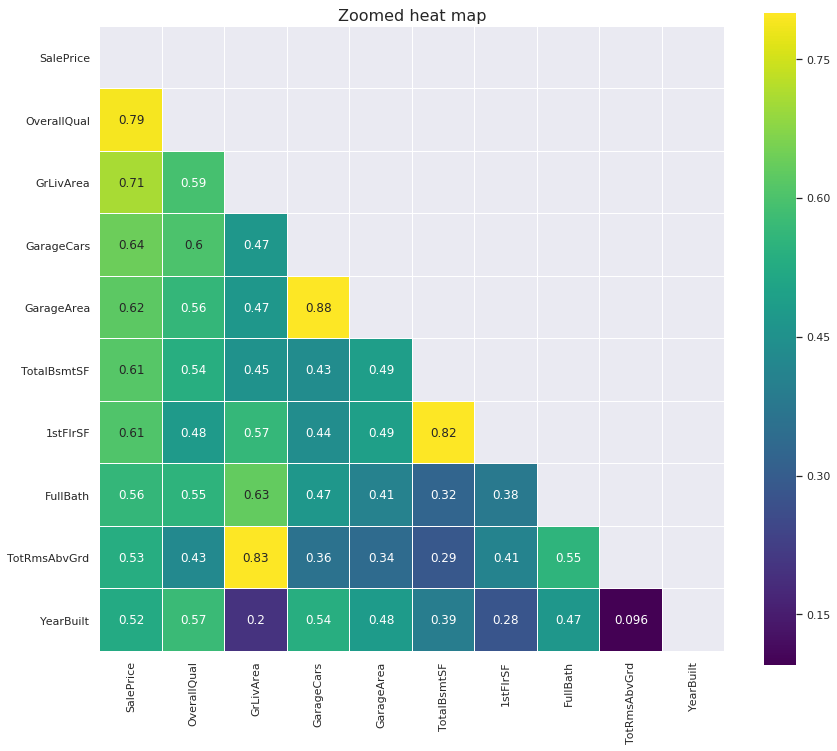

In [632]:
k = 10
cols = correlation.nlargest(k,'SalePrice')['SalePrice'].index
print(cols)

cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14,12))

mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True

plt.title('Zoomed heat map', size=16)

with sns.axes_style("white"):
    sns.heatmap(cm, vmax=.8, linewidths=0.01, square=True, annot=True, cmap='viridis',
            linecolor='white', xticklabels = cols, annot_kws = {'size':12}, yticklabels = cols, mask=mask);

In [633]:
# matrix_size = train.select_dtypes(include=[np.object]).shape[1]
# cmatrix = pd.DataFrame(np.zeros((matrix_size, matrix_size)), 
#                        columns = categorical_columsns,
#                        index = categorical_columsns)

# for i in range(matrix_size):
#     for j in range(matrix_size):
#         confusion_matrix = pd.crosstab(train.iloc[:, i], train.iloc[:, j]).as_matrix()
#         cmatrix.iloc[i, j] = cramers_v(confusion_matrix)

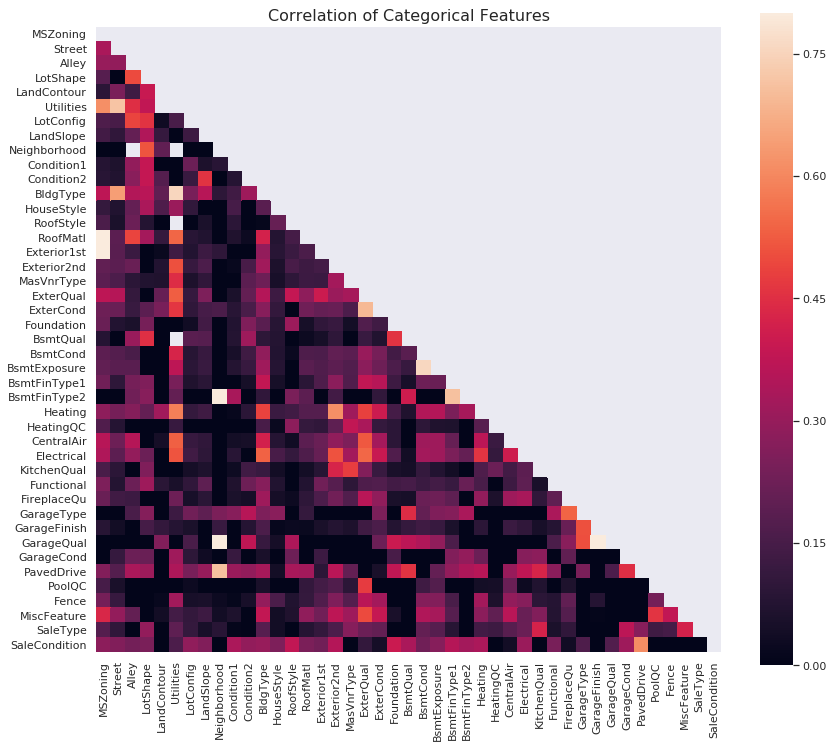

In [634]:
fig, axes = plt.subplots(figsize = (14, 12))

plt.title('Correlation of Categorical Features', size=16)

mask = np.zeros_like(cmatrix)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    sns.heatmap(cmatrix, square = True, vmax=0.8, mask=mask);


In [635]:
# f = pd.melt(train, id_vars=['SalePrice'], value_vars=categorical_columsns)
# g = sns.FacetGrid(f, col='variable',  col_wrap=2, sharex=False, sharey=False, size=5)
# print('Distribution of SalePrice with respect to categorical features')
# g = g.map(boxplot, 'value', 'SalePrice')

## Outliars

As written in documentation http://jse.amstat.org/v19n3/decock.pdf:

*Potential Pitfalls (Outliers): Although all known errors were corrected in the data, no observations have been removed due to unusual values and all final residential sales from the initial data set are included in the data presented with this article. There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students.*

So we can find and delete this outliars.

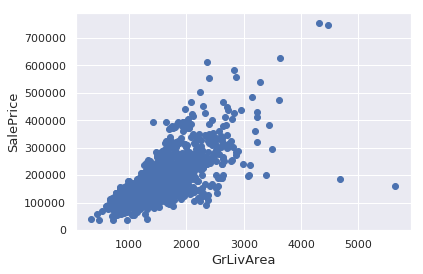

In [636]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

We add additional condition in order not to delete unusual sales (very large houses priced relatively appropriately). I have compared, and it worked slightly better.

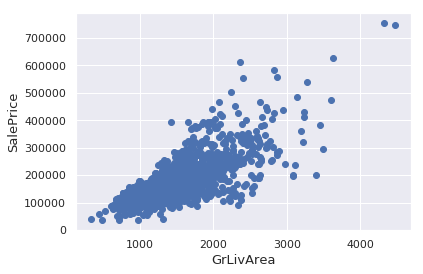

In [1016]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

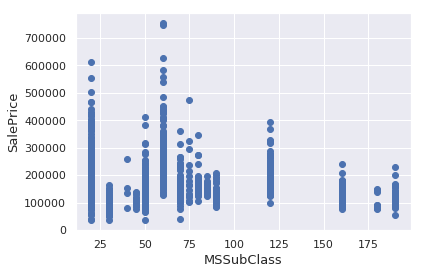

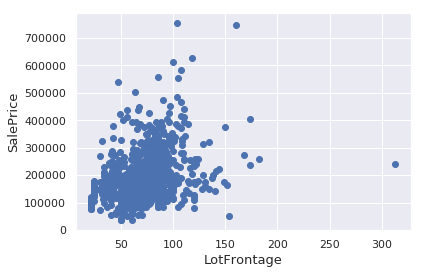

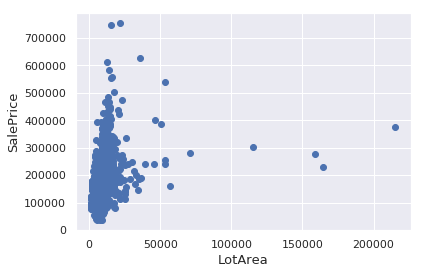

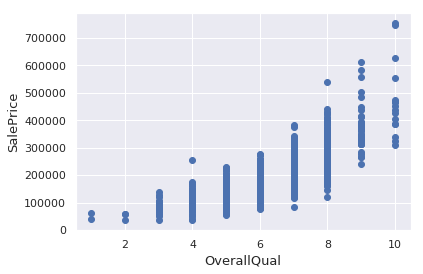

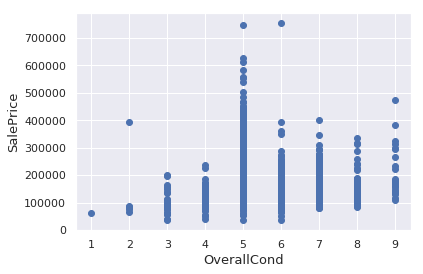

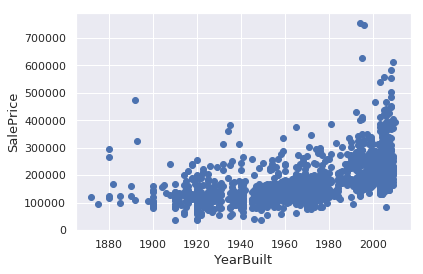

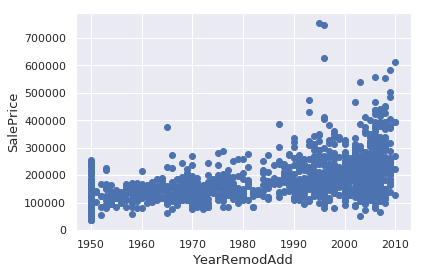

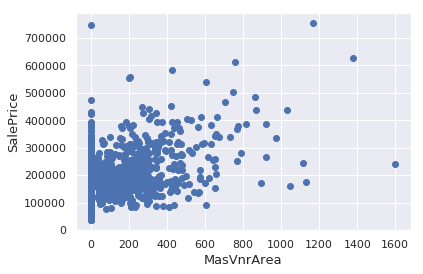

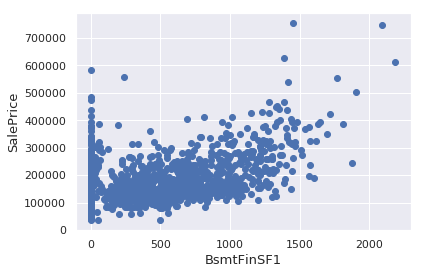

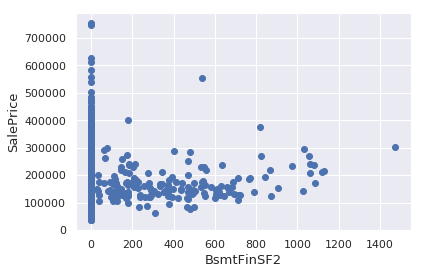

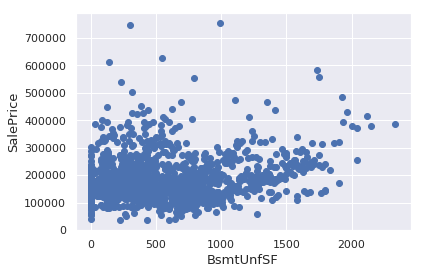

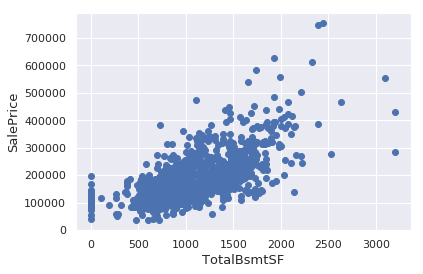

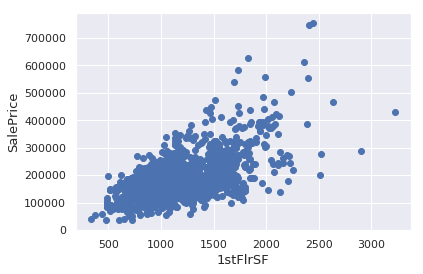

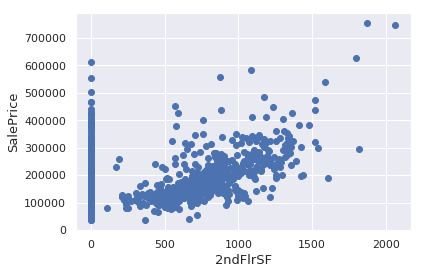

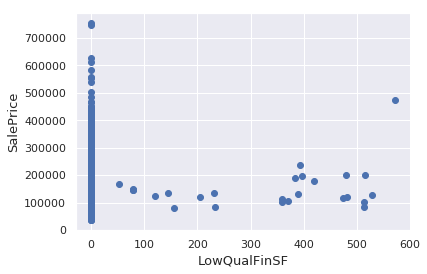

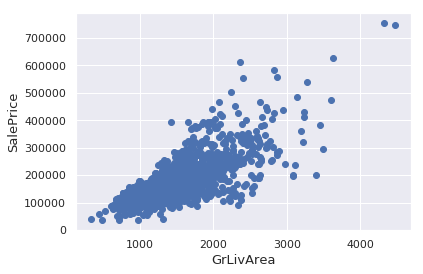

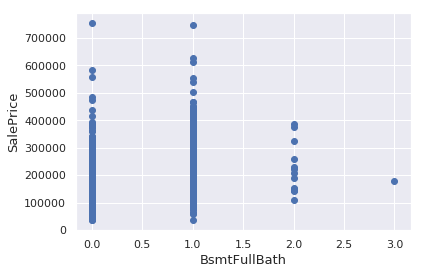

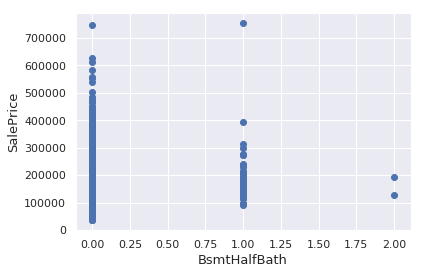

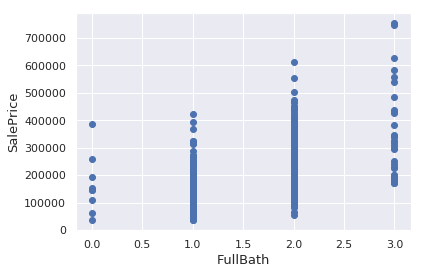

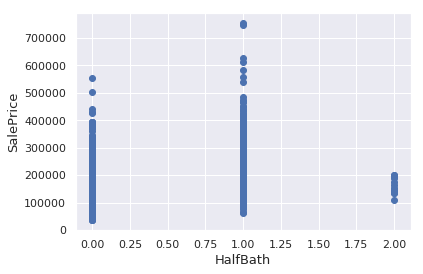

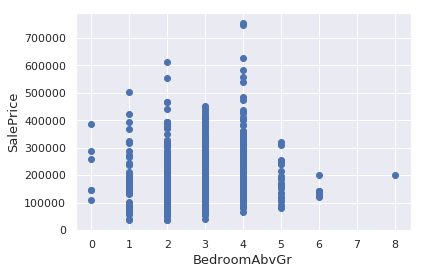

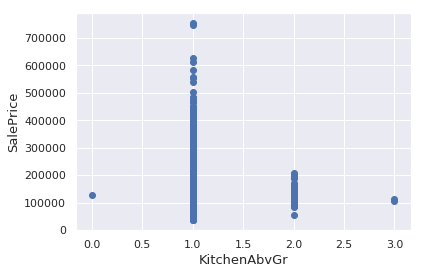

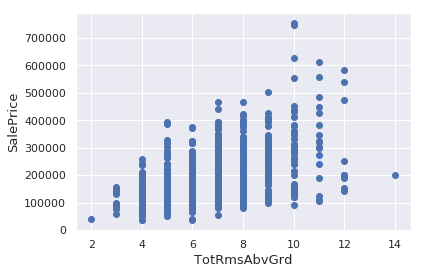

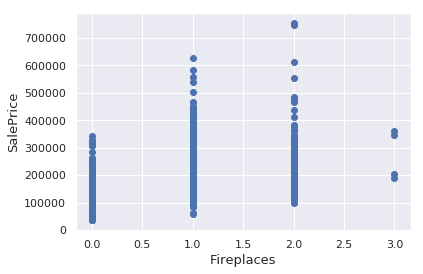

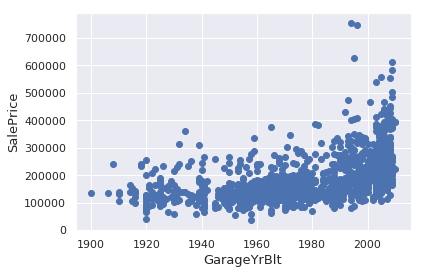

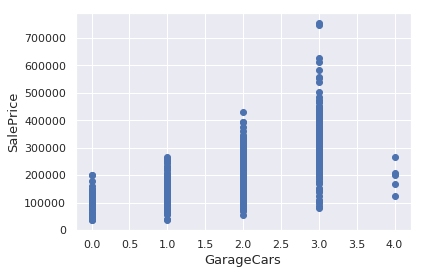

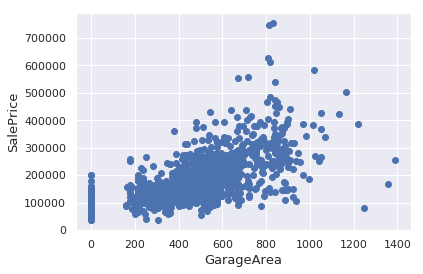

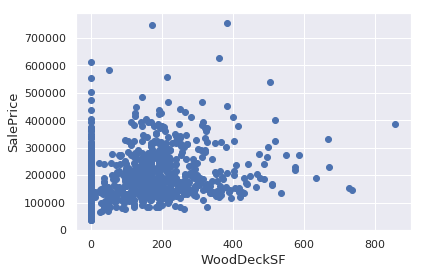

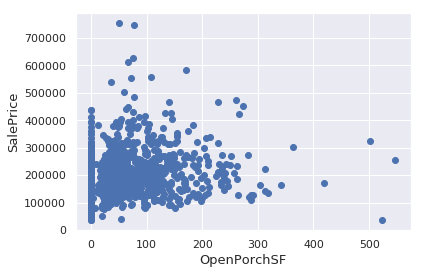

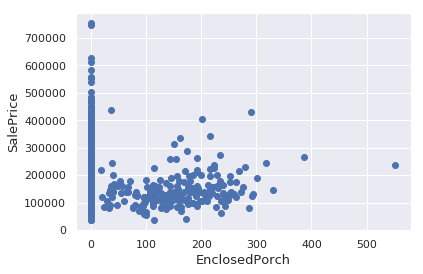

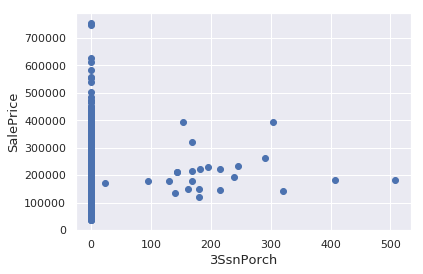

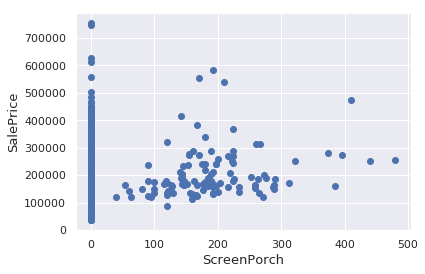

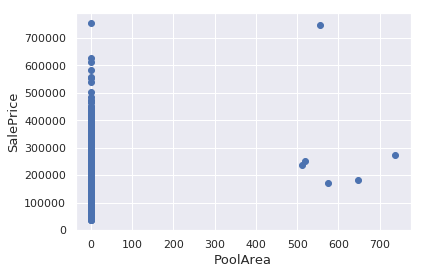

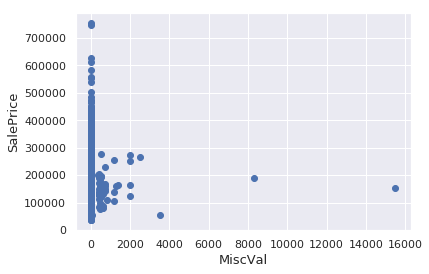

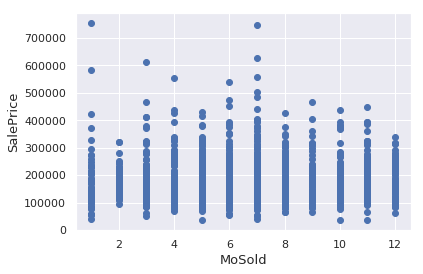

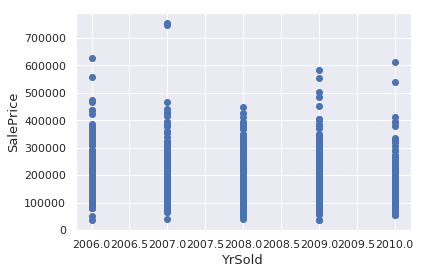

In [861]:
for el in numerical_columns:
    fig, ax = plt.subplots()
    ax.scatter(x = train[el], y = train['SalePrice'])
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel(el, fontsize=13)
    plt.show()

In [1017]:
train = train.drop(train[(train['LotArea']>100000)].index)
train = train.drop(train[(train['MasVnrArea']>1500)].index)
train = train.drop(train[(train['EnclosedPorch']>500)].index)

## Handling missing values

In [1018]:
X_train = train.copy()
y_train = X_train[['SalePrice']]
X_train.drop(['SalePrice'], axis=1, inplace=True)
X_test = test.copy()

### Categorical features

In [1019]:
imp_cat = SimpleImputer(missing_values=np.nan, 
                        strategy='constant', 
                        fill_value='no' + categorical_columsns)

X_train[categorical_columsns] = imp_cat.fit_transform(X_train[categorical_columsns])
X_test[categorical_columsns] = imp_cat.transform(X_test[categorical_columsns])

### Numerical features

In [1020]:
imp_num= SimpleImputer(missing_values=np.nan, 
                        strategy='mean')

X_train[numerical_columns] = imp_num.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = imp_num.transform(X_test[numerical_columns])

In [1021]:
print('Missing values X_train: ' + 
      str(X_train.isnull().sum()[X_train.isnull().sum() > 0].size))

print('Missing values X_test: ' + 
      str(X_test.isnull().sum()[X_test.isnull().sum() > 0].size))


Missing values X_train: 0
Missing values X_test: 0


## Feature normalization

### Visualizations of target

**Skewness and Kurtosis of target**

In [1022]:
print('Skewness: {:.4}'.format(y_train.skew()[0]))
print('Kurtosis: {:.4}'.format(y_train.kurt()[0]))

Skewness: 1.9
Kurtosis: 6.638


**Target distributions**

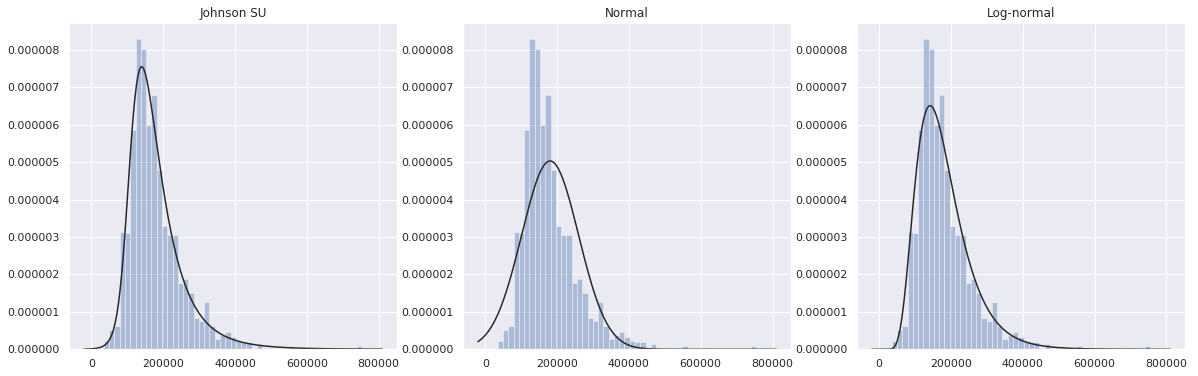

In [1023]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

axes[0].set_title('Johnson SU')
axes[1].set_title('Normal')
axes[2].set_title('Log-normal')
sns.distplot(y_train, kde=False, fit=st.johnsonsu, ax=axes[0]);
sns.distplot(y_train, kde=False, fit=st.norm, ax=axes[1]);
sns.distplot(y_train, kde=False, fit=st.lognorm, ax=axes[2]);

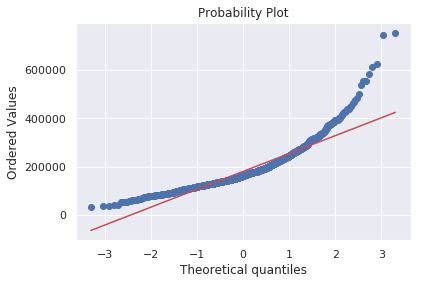

In [1024]:
st.probplot(y_train.iloc[:, 0], plot=plt);

In [1025]:
st.shapiro(y_train)

(0.8680379986763, 2.6383472955817067e-33)

**Make target normal again**

In [1026]:
pt_target = PowerTransformer(method='yeo-johnson')
y_train['SalePrice'] = pt_target.fit_transform(y_train)
st.shapiro(y_train)

(0.9913146495819092, 1.4585366159280966e-07)

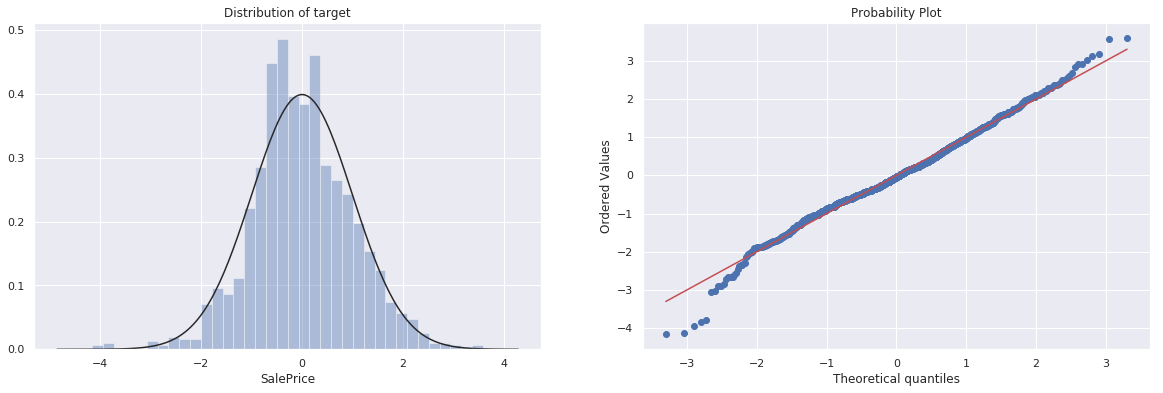

In [1027]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

axes[0].set_title('Distribution of target')
sns.distplot(y_train['SalePrice'], kde=False, fit=st.norm, ax=axes[0]);
st.probplot(y_train['SalePrice'], plot=axes[1]);

### Normalize numeric features

In [1028]:
pt_feat = PowerTransformer(method='yeo-johnson')
scaler = StandardScaler()
robust = RobustScaler()
frame_list = gauss_like([X_train, X_test], [pt_feat, scaler])
X_train, X_test = frame_list[0], frame_list[1]

Transformed columns: 
MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF2, BsmtUnfSF, 1stFlrSF, LowQualFinSF, GrLivArea, BedroomAbvGr, TotRmsAbvGrd, GarageYrBlt, GarageCars, OpenPorchSF, 3SsnPorch, ScreenPorch, MiscVal, MoSold, YrSold
Scaled columns: 
BsmtFinSF1, TotalBsmtSF, 2ndFlrSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, KitchenAbvGr, Fireplaces, GarageArea, WoodDeckSF, EnclosedPorch, PoolArea


In [1029]:
# f = pd.melt(pd.concat([X_train, y_train], axis=1), id_vars=['SalePrice'], value_vars=categorical_columsns)
# g = sns.FacetGrid(f, col='variable',  col_wrap=2, sharex=False, sharey=False, size=5)
# print('Distribution of SalePrice with respect to categorical features')
# g = g.map(boxplot, 'value', 'SalePrice')

## Encoding categorical data

In [1030]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train = pd.concat([X_train[numerical_columns], 
                     pd.DataFrame(onehot_encoder.
                                  fit_transform(X_train[categorical_columsns]), 
                                  index=X_train.index)], 
                    axis=1)

X_test = pd.concat([X_test[numerical_columns], 
                     pd.DataFrame(onehot_encoder.
                                  transform(X_test[categorical_columsns]), 
                                  index=X_test.index)], 
                    axis=1)

## Finding base parametrs for models

### Lasso Regression:

Trying different spaces of alphas

In [676]:
n_alphas = 200
alphas = np.linspace(0.00000001, 0.1, n_alphas)

kf = KFold(n_splits=5, 
           shuffle=True, 
           random_state=42).get_n_splits(X_train.values)

lasso_cv = LassoCV(alphas=alphas, 
                   cv=kf, 
                   random_state=42, 
                   n_jobs=-1)

lasso_cv.fit(X_train, y_train)

lasso_cv_rmse = np.sqrt((np.mean(-cross_val_score(Lasso(lasso_cv.alpha_), X_train, y_train, cv=kf, 
                scoring='neg_mean_squared_error'))))

lasso_best_alpha = lasso_cv.alpha_

print('Lasso best score: ' + str(lasso_cv_rmse))
print('Lasso best alpha: ' + str(lasso_best_alpha))

Lasso best score: 0.2838523211375278
Lasso best alpha: 0.0015075475376884423


Lasso best score: 0.2833659534110847

Lasso best alpha: 0.0015075475376884423

### Ridge Regression:

Trying different spaces of alphas

In [218]:
n_alphas = 100
ridge_alphas = np.linspace(19, 21, n_alphas)

ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='neg_mean_squared_error', 
                   cv=kf)

ridge_cv.fit(X_train, y_train)

ridge_cv_rmse = np.sqrt((np.mean(-cross_val_score(Ridge(ridge_cv.alpha_), X_train, y_train, cv=kf, 
                scoring='neg_mean_squared_error'))))

ridge_best_alpha = ridge_cv.alpha_

print('Ridge best score: ' + str(ridge_cv_rmse))
print('Ridge best alpha: ' + str(ridge_best_alpha))

Ridge best score: 0.2916281960056402
Ridge best alpha: 20.858585858585858


Ridge best score: 0.2916281960056402

Ridge best alpha: 20.858585858585858

### Elastic Net Regression:

In [239]:
n_alphas = 100
elastic_l1_ratio = np.linspace(0.3, 0.8, 10)
elastic_alphas = np.linspace(0.001, 0.2, n_alphas)


elastic_cv = ElasticNetCV(l1_ratio=elastic_l1_ratio, 
                          alphas=elastic_alphas, 
                          cv=kf, 
                          n_jobs=-1)

elastic_cv.fit(X_train, y_train)

elastic_cv_rmse = np.sqrt((np.mean(-cross_val_score(ElasticNet(elastic_cv.alpha_), X_train, y_train, cv=kf, 
                scoring='neg_mean_squared_error'))))

elastic_best_alpha = elastic_cv.alpha_
elastic_best_l1 = elastic_cv.l1_ratio_

print('Elastic best score: ' + str(elastic_cv_rmse))
print('Elastic best L1: ' + str(elastic_best_l1))
print('Elastic best alpha: ' + str(elastic_best_alpha))

Elastic best score: 0.284775909931625
Elastic best L1: 0.5222222222222221
Elastic best alpha: 0.00301010101010101


Elastic best score: 0.284775909931625

Elastic best L1: 0.5222222222222221

Elastic best alpha: 0.00301010101010101

### Kernel Ridge Regression:

In [257]:
n_alphas = 10
krr_params = {'alpha': np.linspace(0.0001, 10, n_alphas), 
              'kernel': ['linear', 'polynomial'], 
              'degree': np.arange(2, 5), 
              'coef0': np.arange(0, 10, 1)}

krr_gcv = GridSearchCV(KernelRidge(), 
                       krr_params, 
                       cv=kf, 
                       scoring='neg_mean_squared_error', 
                       n_jobs=-1, 
                       verbose=True)



krr_gcv.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([1.0000e-04, 1.1112e+00, 2.2223e+00, 3.3334e+00, 4.4445e+00,
       5.5556e+00, 6.6667e+00, 7.7778e+00, 8.8889e+00, 1.0000e+01]), 'kernel': ['linear', 'polynomial'], 'degree': array([2, 3, 4]), 'coef0': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=True)

In [261]:
krr_cv_rmse = np.sqrt((np.mean(-cross_val_score(KernelRidge(alpha=2.2223, coef0=2, degree=4, kernel='polynomial'), X_train, y_train, cv=kf, 
                scoring='neg_mean_squared_error'))))

krr_best_alpha = krr_gcv.best_params_['alpha']
krr_best_coef0 = krr_gcv.best_params_['coef0']
krr_best_degree = krr_gcv.best_params_['degree']
krr_best_kernel = krr_gcv.best_params_['kernel']

print('Kernel Ridge Regression best score: ' + str(krr_cv_rmse))
print('Kernel Ridge Regression best alpha: ' + str(krr_best_alpha))
print('Kernel Ridge Regression best coef0: ' + str(krr_best_coef0))
print('Kernel Ridge Regression best degree: ' + str(krr_best_degree))
print('Kernel Ridge Regression best kernel: ' + str(krr_best_kernel))




Kernel Ridge Regression best score: 0.2851655918827155
Kernel Ridge Regression best alpha: 2.2223
Kernel Ridge Regression best coef0: 2
Kernel Ridge Regression best degree: 4
Kernel Ridge Regression best kernel: polynomial


In [259]:
krr_gcv.best_params_

{'alpha': 2.2223, 'coef0': 2, 'degree': 4, 'kernel': 'polynomial'}

score: 0.2851655918827155 

{'alpha': 2.2223, 'coef0': 2, 'degree': 4, 'kernel': 'polynomial'}

### Gradient Boosting Regression:

With huber loss that makes it robust to outliers

In [372]:
def score_GB(params):
    print("Training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    model = GradientBoostingRegressor(**params)
    model.fit(X_train_gb, y_train_gb)
    predictions = model.predict(X_valid_gb)
    score = np.sqrt(mean_squared_error(y_valid_gb, predictions))
    print("\tScore {0}\n\n".format(score))
    loss = score
    return {'loss': loss, 'status': STATUS_OK}

def optimize_GB(trials):
    space = {
             'loss':'huber',
             'learning_rate': hp.quniform('learning_rate', 0.005, 0.05, 0.005), 
             'n_estimators': 100, 
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05), 
             'min_samples_split': hp.quniform('min_samples_split', 2, 30, 1),
             'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 20, 1),
             'max_depth': hp.quniform('max_depth', 2, 20, 1),
             'max_features': hp.quniform('max_features', 0.3, 1, 0.05),
             'alpha': hp.quniform('alpha', 0.1, 0.9, 0.05),
             }
    
    best = fmin(score_GB, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [373]:
X_train_gb, X_valid_gb, y_train_gb, y_valid_gb = train_test_split(X_train, 
                                                      y_train, 
                                                      test_size=0.3, 
                                                      random_state=42)

In [374]:
trials = Trials()
best_params_GB = optimize_GB(trials)
best_params_GB

Training with params:                                
{'alpha': 0.65, 'learning_rate': 0.045, 'loss': 'huber', 'max_depth': 19.0, 'max_features': 0.8, 'min_samples_leaf': 15.0, 'min_samples_split': 3.0, 'n_estimators': 100, 'subsample': 0.75}
	Score 0.33417706298332217                           


Training with params:                                                          
{'alpha': 0.30000000000000004, 'learning_rate': 0.035, 'loss': 'huber', 'max_depth': 15.0, 'max_features': 0.7000000000000001, 'min_samples_leaf': 17.0, 'min_samples_split': 13.0, 'n_estimators': 100, 'subsample': 0.7000000000000001}
	Score 0.3572710057908492                                                      


Training with params:                                                          
{'alpha': 0.35000000000000003, 'learning_rate': 0.035, 'loss': 'huber', 'max_depth': 11.0, 'max_features': 0.35000000000000003, 'min_samples_leaf': 10.0, 'min_samples_split': 21.0, 'n_estimators': 100, 'subsample': 0.85000000

	Score 0.3300448581540655                                                       


Training with params:                                                           
{'alpha': 0.45, 'learning_rate': 0.045, 'loss': 'huber', 'max_depth': 7.0, 'max_features': 0.7000000000000001, 'min_samples_leaf': 8.0, 'min_samples_split': 19.0, 'n_estimators': 100, 'subsample': 0.65}
	Score 0.33321089164739254                                                      


Training with params:                                                           
{'alpha': 0.7000000000000001, 'learning_rate': 0.02, 'loss': 'huber', 'max_depth': 9.0, 'max_features': 0.6000000000000001, 'min_samples_leaf': 16.0, 'min_samples_split': 30.0, 'n_estimators': 100, 'subsample': 0.7000000000000001}
	Score 0.40294917892557486                                                      


Training with params:                                                           
{'alpha': 0.8500000000000001, 'learning_rate': 0.025, 'loss': 'huber', 'ma

{'alpha': 0.30000000000000004, 'learning_rate': 0.045, 'loss': 'huber', 'max_depth': 9.0, 'max_features': 0.75, 'min_samples_leaf': 16.0, 'min_samples_split': 27.0, 'n_estimators': 100, 'subsample': 0.6000000000000001}
	Score 0.34150320335032613                                                      


Training with params:                                                           
{'alpha': 0.6000000000000001, 'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 11.0, 'max_features': 0.45, 'min_samples_leaf': 3.0, 'min_samples_split': 28.0, 'n_estimators': 100, 'subsample': 0.65}
	Score 0.3251916774635752                                                       


Training with params:                                                           
{'alpha': 0.55, 'learning_rate': 0.04, 'loss': 'huber', 'max_depth': 16.0, 'max_features': 0.8500000000000001, 'min_samples_leaf': 11.0, 'min_samples_split': 9.0, 'n_estimators': 100, 'subsample': 0.6000000000000001}
	Score 0.3386355532737908        

{'alpha': 0.9,
 'learning_rate': 0.05,
 'max_depth': 5.0,
 'max_features': 0.75,
 'min_samples_leaf': 5.0,
 'min_samples_split': 17.0,
 'subsample': 0.65}

In [375]:
best_params_GB['max_depth'] = int(best_params_GB['max_depth'])
best_params_GB['min_samples_leaf'] = int(best_params_GB['min_samples_leaf'])
best_params_GB['min_samples_split'] = int(best_params_GB['min_samples_split'])

[el + '=' + str(best_params_GB[el]) for el in best_params_GB]


['alpha=0.9',
 'learning_rate=0.05',
 'max_depth=5',
 'max_features=0.75',
 'min_samples_leaf=5',
 'min_samples_split=17',
 'subsample=0.65']

['alpha=0.9',
 'learning_rate=0.05',
 'max_depth=5',
 'max_features=0.75',
 'min_samples_leaf=5',
 'min_samples_split=17',
 'subsample=0.65']

In [378]:
gb_rmse = rmsle_cv(GradientBoostingRegressor(n_estimators=3000,
                                             loss='huber',
                                             alpha=0.9, 
                                             learning_rate=0.05, 
                                             max_depth=5, 
                                             max_features=0.75, 
                                             min_samples_leaf=5, 
                                             min_samples_split=17, 
                                             subsample=0.65, 
                                             random_state=42, 
                                             n_iter_no_change=100), 
                   X_train, y_train)

In [379]:
print('Gradient Boosting Regression best score: ' + str(np.mean(gb_rmse)))

Gradient Boosting Regression best score: 0.3034719322867967


### XGBoost tree:

In [419]:
def score_XGB_tree(params):
    print("Training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train_gb, label=y_train_gb)
    dvalid = xgb.DMatrix(X_valid_gb, label=y_valid_gb)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid)
    score = np.sqrt(mean_squared_error(y_valid_gb, predictions))
    print("\tScore {0}\n\n".format(score))
    loss = score
    return {'loss': loss, 'status': STATUS_OK}

def optimize_XGB_tree(trials):
    space = {
             'booster': 'gbtree', 
             'learning_rate': hp.quniform('learning_rate', 0.005, 0.5, 0.005),
             'gamma': hp.quniform('gamma', 0, 10, 1),
             'max_depth': hp.quniform('max_depth', 2, 20, 1),
             'min_child_weight': hp.quniform('min_child_weight', 0.1, 1, 0.05),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'colsample_bytree': hp.quniform('colsample_bytree', 0, 1, 0.05), 
             'colsample_bylevel': hp.quniform('colsample_bylevel', 0, 1, 0.05), 
             'colsample_bynode': hp.quniform('colsample_bynode', 0, 1, 0.05),
             'reg_lambda': hp.quniform('reg_lambda', 0.1, 0.9, 0.05),
             'alpha': hp.quniform('alpha', 0.1, 0.9, 0.05),
             'objective': 'reg:linear',
             'eval_metric': 'rmse',
             'seed': 42, 
             'num_round': 500,
             'nthread' : -1,
             'silent' : 1
             }
    
    best = fmin(score_XGB_tree, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [389]:
trials = Trials()
best_params_XGB_tree = optimize_XGB_tree(trials)
best_params_XGB_tree

Training with params:                                
{'alpha': 0.8500000000000001, 'booster': 'gbtree', 'colsample_bylevel': 0.4, 'colsample_bynode': 0.15000000000000002, 'colsample_bytree': 0.30000000000000004, 'eval_metric': 'rmse', 'gamma': 4.0, 'lambda': 0.4, 'learning_rate': 0.2, 'max_depth': 18.0, 'min_child_weight': 0.9500000000000001, 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'seed': 42, 'silent': 1, 'subsample': 0.75}
	Score 0.3767594585078168                            


Training with params:                                                         
{'alpha': 0.9, 'booster': 'gbtree', 'colsample_bylevel': 0.30000000000000004, 'colsample_bynode': 0.45, 'colsample_bytree': 0.65, 'eval_metric': 'rmse', 'gamma': 4.0, 'lambda': 0.65, 'learning_rate': 0.24, 'max_depth': 7.0, 'min_child_weight': 0.65, 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'seed': 42, 'silent': 1, 'subsample': 0.7000000000000001}
	Score 0.3715184728560566                      

	Score 0.42948302618343004                                                     


Training with params:                                                          
{'alpha': 0.8, 'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bynode': 0.15000000000000002, 'colsample_bytree': 0.25, 'eval_metric': 'rmse', 'gamma': 4.0, 'lambda': 0.55, 'learning_rate': 0.12, 'max_depth': 14.0, 'min_child_weight': 0.75, 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'seed': 42, 'silent': 1, 'subsample': 0.6000000000000001}
	Score 0.356971855295281                                                       


Training with params:                                                          
{'alpha': 0.55, 'booster': 'gbtree', 'colsample_bylevel': 0.15000000000000002, 'colsample_bynode': 0.1, 'colsample_bytree': 0.35000000000000003, 'eval_metric': 'rmse', 'gamma': 7.0, 'lambda': 0.15000000000000002, 'learning_rate': 0.185, 'max_depth': 14.0, 'min_child_weight': 0.30000000000000004, 'nthread': 

Training with params:                                                           
{'alpha': 0.4, 'booster': 'gbtree', 'colsample_bylevel': 0.55, 'colsample_bynode': 0.2, 'colsample_bytree': 0.15000000000000002, 'eval_metric': 'rmse', 'gamma': 3.0, 'lambda': 0.25, 'learning_rate': 0.265, 'max_depth': 6.0, 'min_child_weight': 0.25, 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'seed': 42, 'silent': 1, 'subsample': 0.65}
	Score 0.34782449650962854                                                      


Training with params:                                                           
{'alpha': 0.1, 'booster': 'gbtree', 'colsample_bylevel': 0.5, 'colsample_bynode': 0.4, 'colsample_bytree': 0.30000000000000004, 'eval_metric': 'rmse', 'gamma': 1.0, 'lambda': 0.75, 'learning_rate': 0.425, 'max_depth': 10.0, 'min_child_weight': 0.4, 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'seed': 42, 'silent': 1, 'subsample': 0.9500000000000001}
	Score 0.34415964615122224        

{'alpha': 0.9, 'booster': 'gbtree', 'colsample_bylevel': 0.45, 'colsample_bynode': 0.15000000000000002, 'colsample_bytree': 0.8500000000000001, 'eval_metric': 'rmse', 'gamma': 0.0, 'lambda': 0.25, 'learning_rate': 0.005, 'max_depth': 5.0, 'min_child_weight': 0.9, 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'seed': 42, 'silent': 1, 'subsample': 0.8}
	Score 0.37059619263576027                                                      


Training with params:                                                           
{'alpha': 0.8500000000000001, 'booster': 'gbtree', 'colsample_bylevel': 0.30000000000000004, 'colsample_bynode': 0.05, 'colsample_bytree': 0.9500000000000001, 'eval_metric': 'rmse', 'gamma': 1.0, 'lambda': 0.2, 'learning_rate': 0.045, 'max_depth': 3.0, 'min_child_weight': 0.8, 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'seed': 42, 'silent': 1, 'subsample': 0.9}
	Score 0.31574820961483263                                                      


Train

	Score 0.30765470352203766                                                      


Training with params:                                                           
{'alpha': 0.2, 'booster': 'gbtree', 'colsample_bylevel': 0.65, 'colsample_bynode': 0.1, 'colsample_bytree': 1.0, 'eval_metric': 'rmse', 'gamma': 4.0, 'lambda': 0.45, 'learning_rate': 0.04, 'max_depth': 15.0, 'min_child_weight': 0.8, 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'seed': 42, 'silent': 1, 'subsample': 1.0}
	Score 0.37230514570140255                                                      


Training with params:                                                           
{'alpha': 0.6000000000000001, 'booster': 'gbtree', 'colsample_bylevel': 0.30000000000000004, 'colsample_bynode': 0.4, 'colsample_bytree': 0.8500000000000001, 'eval_metric': 'rmse', 'gamma': 2.0, 'lambda': 0.1, 'learning_rate': 0.11, 'max_depth': 5.0, 'min_child_weight': 0.6000000000000001, 'nthread': -1, 'num_round': 500, 'objective':

{'alpha': 0.8,
 'colsample_bylevel': 0.4,
 'colsample_bynode': 0.1,
 'colsample_bytree': 0.9500000000000001,
 'gamma': 0.0,
 'lambda': 0.30000000000000004,
 'learning_rate': 0.125,
 'max_depth': 2.0,
 'min_child_weight': 0.9500000000000001,
 'subsample': 1.0}

In [390]:
best_params_XGB_tree['max_depth'] = int(best_params_XGB_tree['max_depth'])

In [391]:
[el + '=' + str(best_params_XGB_tree[el]) for el in best_params_XGB_tree]

['alpha=0.8',
 'colsample_bylevel=0.4',
 'colsample_bynode=0.1',
 'colsample_bytree=0.9500000000000001',
 'gamma=0.0',
 'lambda=0.30000000000000004',
 'learning_rate=0.125',
 'max_depth=2',
 'min_child_weight=0.9500000000000001',
 'subsample=1.0']

['alpha=0.8',
 'colsample_bylevel=0.4',
 'colsample_bynode=0.1',
 'colsample_bytree=0.9500000000000001',
 'gamma=0.0',
 'lambda=0.30000000000000004',
 'learning_rate=0.125',
 'max_depth=2',
 'min_child_weight=0.9500000000000001',
 'subsample=1.0']

In [393]:
xgb_tree_rmse = rmsle_cv(xgb.XGBRegressor(n_estimators=3000, 
                                          alpha=0.8, 
                                          colsample_bylevel=0.4, 
                                          colsample_bynode=0.1, 
                                          colsample_bytree=0.9500000000000001, 
                                          gamma=0.0, 
                                          reg_lambda=0.3000000000000000, 
                                          learning_rate=0.125, 
                                          max_depth=2, 
                                          min_child_weight=0.9500000000000001, 
                                          subsample=1.0, 
                                          random_state=42), 
                         X_train, y_train)

In [394]:
print('XGB tree best score: ' + str(np.mean(xgb_tree_rmse)))

XGB tree best score: 0.31112249530658054


### XGBoost linear:

In [413]:
def score_XGB_linear(params):
    print("Training with params:")
    print(params)
    dtrain = xgb.DMatrix(X_train_gb, label=y_train_gb)
    dvalid = xgb.DMatrix(X_valid_gb, label=y_valid_gb)
    model = xgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(dvalid)
    score = np.sqrt(mean_squared_error(y_valid_gb, predictions))
    print("\tScore {0}\n\n".format(score))
    loss = score
    return {'loss': loss, 'status': STATUS_OK}

def optimize_XGB_linear(trials):
    space = {
             'booster': 'gblinear', 
             'reg_lambda': hp.quniform('reg_lambda', 0.1, 0.9, 0.05),
             'alpha': hp.quniform('alpha', 0.1, 0.9, 0.05),
             'feature_selector': hp.choice('feature_selector', ['cyclic', 'shuffle']),
             'objective': 'reg:linear',
             'eval_metric': 'rmse',
             'seed': 42, 
             'num_round': 500,
             'nthread' : -1,
             'silent' : 1
             }

    best = fmin(score_XGB_linear, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [414]:
trials = Trials()
best_params_XGB_linear = optimize_XGB_linear(trials)
best_params_XGB_linear

Training with params:                                
{'alpha': 0.65, 'booster': 'gblinear', 'eval_metric': 'rmse', 'feature_selector': 'cyclic', 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'reg_lambda': 0.5, 'seed': 42, 'silent': 1}
	Score 0.8995819571458029                            


Training with params:                                                         
{'alpha': 0.15000000000000002, 'booster': 'gblinear', 'eval_metric': 'rmse', 'feature_selector': 'shuffle', 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'reg_lambda': 0.65, 'seed': 42, 'silent': 1}
	Score 0.475912246513809                                                      


Training with params:                                                         
{'alpha': 0.55, 'booster': 'gblinear', 'eval_metric': 'rmse', 'feature_selector': 'shuffle', 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'reg_lambda': 0.45, 'seed': 42, 'silent': 1}
	Score 0.821845519574132                    

	Score 0.40316468272025724                                                      


Training with params:                                                           
{'alpha': 0.1, 'booster': 'gblinear', 'eval_metric': 'rmse', 'feature_selector': 'shuffle', 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'reg_lambda': 0.1, 'seed': 42, 'silent': 1}
	Score 0.39999994407929623                                                      


Training with params:                                                           
{'alpha': 0.35000000000000003, 'booster': 'gblinear', 'eval_metric': 'rmse', 'feature_selector': 'shuffle', 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'reg_lambda': 0.15000000000000002, 'seed': 42, 'silent': 1}
	Score 0.6174840057888594                                                       


Training with params:                                                           
{'alpha': 0.15000000000000002, 'booster': 'gblinear', 'eval_metric': 'rmse', 'featur

	Score 0.4461828586629575                                                       


Training with params:                                                           
{'alpha': 0.25, 'booster': 'gblinear', 'eval_metric': 'rmse', 'feature_selector': 'shuffle', 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'reg_lambda': 0.45, 'seed': 42, 'silent': 1}
	Score 0.5524314508718288                                                       


Training with params:                                                           
{'alpha': 0.4, 'booster': 'gblinear', 'eval_metric': 'rmse', 'feature_selector': 'shuffle', 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'reg_lambda': 0.65, 'seed': 42, 'silent': 1}
	Score 0.7043085995300262                                                       


Training with params:                                                           
{'alpha': 0.15000000000000002, 'booster': 'gblinear', 'eval_metric': 'rmse', 'feature_selector': 'cyclic', 'nthre

	Score 0.5291078082170442                                                       


Training with params:                                                           
{'alpha': 0.30000000000000004, 'booster': 'gblinear', 'eval_metric': 'rmse', 'feature_selector': 'shuffle', 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'reg_lambda': 0.30000000000000004, 'seed': 42, 'silent': 1}
	Score 0.5868502241305786                                                       


Training with params:                                                           
{'alpha': 0.8500000000000001, 'booster': 'gblinear', 'eval_metric': 'rmse', 'feature_selector': 'cyclic', 'nthread': -1, 'num_round': 500, 'objective': 'reg:linear', 'reg_lambda': 0.45, 'seed': 42, 'silent': 1}
	Score 0.9951044864052497                                                       


Training with params:                                                           
{'alpha': 0.15000000000000002, 'booster': 'gblinear', 'eval_metric': 

In [415]:
[el + '=' + str(best_params_XGB_linear[el]) for el in best_params_XGB_linear]

['alpha=0.1', 'feature_selector=1', 'reg_lambda=0.1']

['alpha=0.1', 'feature_selector='shuffle', 'reg_lambda=0.1']

In [417]:
xgb_linear_rmse = rmsle_cv(xgb.XGBRegressor(n_estimators=3000, 
                                            alpha=0.1, 
                                            booster='gblinear', 
                                            eval_metric='rmse', 
                                            feature_selector='shuffle', 
                                            nthread= -1, 
                                            num_round=500, 
                                            objective='reg:linear', 
                                            reg_lambda=0.1, 
                                            seed=42, 
                                            silent=1), 
                   X_train, y_train)

In [418]:
print('XGB linear best score: ' + str(np.mean(xgb_linear_rmse)))

XGB linear best score: 0.29785123384648393


### LightGBM:

In [433]:
def score_LGB(params):
    print("Training with params:")
    print(params)
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
    params['bagging_freq'] = int(params['bagging_freq'])
    params['max_bin'] = int(params['max_bin'])
    dtrain = lgb.Dataset(X_train_gb, label=y_train_gb)
    dvalid = lgb.Dataset(X_valid_gb, label=y_valid_gb)
    model = lgb.train(params, dtrain, params['num_round'])
    predictions = model.predict(X_valid_gb)
    score = np.sqrt(mean_squared_error(y_valid_gb, predictions))
    print("\tScore {0}\n\n".format(score))
    loss = score
    return {'loss': loss, 'status': STATUS_OK}

def optimize_LGB(trials):
    space = {
             'objective': 'huber',
             'boosting': 'gbdt',
             'num_round': 500,
             'learning_rate': hp.quniform('learning_rate', 0.005, 0.5, 0.005),
             'num_leaves': hp.quniform('num_leaves', 2, 40, 1),
             'nthread' : 4,
             'seed': 42,
             'max_depth': hp.quniform('max_depth', 2, 20, 1),
             'min_data_in_leaf': hp.quniform('min_data_in_leaf', 2, 30, 1),
             'min_sum_hessian_in_leaf': hp.quniform('min_sum_hessian_in_leaf', 0.001, 30, 1),
             'subsample': hp.quniform('subsample', 0.3, 1, 0.05),
             'bagging_freq': hp.quniform('bagging_freq', 0, 10, 1),
             'bagging_seed': 42,
             'feature_fraction': hp.quniform('colsample_bytree', 0.1, 1, 0.05),
             'feature_fraction_seed': 42,
             'lambda_l1': hp.quniform('lambda_l1', 0.1, 0.9, 0.05),
             'lambda_l2': hp.quniform('lambda_l2', 0.1, 0.9, 0.05),
             'max_bin': hp.quniform('max_bin', 15, 255, 20),
             'metric': 'rmse'
            }
    

    best = fmin(score_LGB, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [434]:
trials = Trials()
best_params_LGB = optimize_LGB(trials)
best_params_LGB

Training with params:                                
{'bagging_freq': 2.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.6000000000000001, 'feature_fraction_seed': 42, 'lambda_l1': 0.45, 'lambda_l2': 0.65, 'learning_rate': 0.34, 'max_bin': 20.0, 'max_depth': 8.0, 'metric': 'rmse', 'min_data_in_leaf': 17.0, 'min_sum_hessian_in_leaf': 3.0, 'nthread': 4, 'num_leaves': 23.0, 'num_round': 500, 'objective': 'huber', 'seed': 42, 'subsample': 0.6000000000000001}
	Score 0.38456908263985795                           


Training with params:                                                          
{'bagging_freq': 3.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.5, 'feature_fraction_seed': 42, 'lambda_l1': 0.8500000000000001, 'lambda_l2': 0.1, 'learning_rate': 0.4, 'max_bin': 120.0, 'max_depth': 14.0, 'metric': 'rmse', 'min_data_in_leaf': 7.0, 'min_sum_hessian_in_leaf': 4.0, 'nthread': 4, 'num_leaves': 39.0, 'num_round': 500, 'objective': 'huber', 'seed': 42, '

{'bagging_freq': 9.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.9500000000000001, 'feature_fraction_seed': 42, 'lambda_l1': 0.15000000000000002, 'lambda_l2': 0.9, 'learning_rate': 0.075, 'max_bin': 20.0, 'max_depth': 8.0, 'metric': 'rmse', 'min_data_in_leaf': 16.0, 'min_sum_hessian_in_leaf': 14.0, 'nthread': 4, 'num_leaves': 17.0, 'num_round': 500, 'objective': 'huber', 'seed': 42, 'subsample': 0.55}
	Score 0.34539263247755525                                                     


Training with params:                                                          
{'bagging_freq': 4.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.65, 'feature_fraction_seed': 42, 'lambda_l1': 0.15000000000000002, 'lambda_l2': 0.9, 'learning_rate': 0.215, 'max_bin': 40.0, 'max_depth': 12.0, 'metric': 'rmse', 'min_data_in_leaf': 22.0, 'min_sum_hessian_in_leaf': 3.0, 'nthread': 4, 'num_leaves': 9.0, 'num_round': 500, 'objective': 'huber', 'seed': 42, 'subsample': 0.75}
	Scor

	Score 0.32558146446045916                                                     


Training with params:                                                          
{'bagging_freq': 3.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.30000000000000004, 'feature_fraction_seed': 42, 'lambda_l1': 0.55, 'lambda_l2': 0.8, 'learning_rate': 0.195, 'max_bin': 140.0, 'max_depth': 15.0, 'metric': 'rmse', 'min_data_in_leaf': 3.0, 'min_sum_hessian_in_leaf': 18.0, 'nthread': 4, 'num_leaves': 11.0, 'num_round': 500, 'objective': 'huber', 'seed': 42, 'subsample': 1.0}
	Score 0.33719563615727705                                                     


Training with params:                                                          
{'bagging_freq': 8.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.1, 'feature_fraction_seed': 42, 'lambda_l1': 0.25, 'lambda_l2': 0.15000000000000002, 'learning_rate': 0.035, 'max_bin': 80.0, 'max_depth': 10.0, 'metric': 'rmse', 'min_data_in_leaf':

{'bagging_freq': 9.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.65, 'feature_fraction_seed': 42, 'lambda_l1': 0.8, 'lambda_l2': 0.75, 'learning_rate': 0.115, 'max_bin': 220.0, 'max_depth': 2.0, 'metric': 'rmse', 'min_data_in_leaf': 2.0, 'min_sum_hessian_in_leaf': 13.0, 'nthread': 4, 'num_leaves': 3.0, 'num_round': 500, 'objective': 'huber', 'seed': 42, 'subsample': 0.5}
	Score 0.31822074484335156                                                      


Training with params:                                                           
{'bagging_freq': 8.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'feature_fraction_seed': 42, 'lambda_l1': 0.7000000000000001, 'lambda_l2': 0.7000000000000001, 'learning_rate': 0.21, 'max_bin': 260.0, 'max_depth': 3.0, 'metric': 'rmse', 'min_data_in_leaf': 3.0, 'min_sum_hessian_in_leaf': 9.0, 'nthread': 4, 'num_leaves': 5.0, 'num_round': 500, 'objective': 'huber', 'seed': 42, 'subsample': 0.6000000000000001}
	Score 0.

	Score 0.3442445688785104                                                       


Training with params:                                                           
{'bagging_freq': 6.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.65, 'feature_fraction_seed': 42, 'lambda_l1': 0.55, 'lambda_l2': 0.45, 'learning_rate': 0.295, 'max_bin': 260.0, 'max_depth': 4.0, 'metric': 'rmse', 'min_data_in_leaf': 15.0, 'min_sum_hessian_in_leaf': 30.0, 'nthread': 4, 'num_leaves': 33.0, 'num_round': 500, 'objective': 'huber', 'seed': 42, 'subsample': 0.7000000000000001}
	Score 0.3490672702205446                                                       


Training with params:                                                           
{'bagging_freq': 9.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.8500000000000001, 'feature_fraction_seed': 42, 'lambda_l1': 0.6000000000000001, 'lambda_l2': 0.75, 'learning_rate': 0.03, 'max_bin': 260.0, 'max_depth': 6.0, 'metric': 'rmse', '

{'bagging_freq': 6.0,
 'colsample_bytree': 0.7000000000000001,
 'lambda_l1': 0.55,
 'lambda_l2': 0.9,
 'learning_rate': 0.045,
 'max_bin': 260.0,
 'max_depth': 2.0,
 'min_data_in_leaf': 16.0,
 'min_sum_hessian_in_leaf': 10.0,
 'num_leaves': 6.0,
 'subsample': 0.8500000000000001}

'bagging_freq': 6.0, 'bagging_seed': 42, 'boosting': 'gbdt', 'feature_fraction': 0.7000000000000001, 'feature_fraction_seed': 42, 'lambda_l1': 0.55, 'lambda_l2': 0.9, 'learning_rate': 0.045, 'max_bin': 260.0, 'max_depth': 2.0, 'metric': 'rmse', 'min_data_in_leaf': 16.0, 'min_sum_hessian_in_leaf': 10.0, 'nthread': 4, 'num_leaves': 6.0, 'num_round': 500, 'objective': 'huber', 'seed': 42, 'subsample': 0.8500000000000001

In [438]:
lgb_rmse = rmsle_cv(lgb.LGBMRegressor(n_estimators=3000, 
                                      bagging_freq=6, 
                                      bagging_seed=42, 
                                      boosting='gbdt', 
                                      feature_fraction=0.7000000000000001, 
                                      feature_fraction_seed=42, 
                                      lambda_l1=0.55, 
                                      lambda_l2=0.9, 
                                      learning_rate=0.045, 
                                      max_bin=260, 
                                      max_depth=2, 
                                      metric='rmse', 
                                      min_data_in_leaf=16, 
                                      min_sum_hessian_in_leaf=10, 
                                      nthread=4, 
                                      num_leaves=6, 
                                      num_round=500, 
                                      objective='huber', 
                                      seed=42, 
                                      subsample=0.8500000000000001), 
                   X_train, y_train)

In [439]:
print('LightGBM best score: ' + str(np.mean(lgb_rmse)))

LightGBM best score: 0.30602079343781113


### **We will use parametrs below to tune features and compare results:**

Save it as markdown to avoid accidentally erasing

**Lasso:**  
score: 0.2834  
alpha=0.00151

**Ridge:**  
score: 0.2916  
alpha=20.86

**Elastic:**   
score: 0.2848  
l1_ratio=0.52, alpha=0.003  

**Kernel Ridge:**  
score: 0.2852  
alpha=2.22, coef0=2, degree=4, kernel=polynomial  

**Gradient Boosting Regression:**  
score: 0.3035  
n_estimators=3000, loss='huber', alpha=0.9, learning_rate=0.05, max_depth=5, max_features=0.75, min_samples_leaf=5, min_samples_split=17, subsample=0.65, random_state=42, n_iter_no_change=100

**XGB tree:**  
score: 0.3111  
n_estimators=3000, alpha=0.8, colsample_bylevel=0.4, colsample_bynode=0.1, colsample_bytree=0.95, gamma=0.0, reg_lambda=0.3, learning_rate=0.125, max_depth=2, min_child_weight=0.95, subsample=1.0, random_state=42  

**XGB linear:**  
score: 0.2979  
n_estimators=3000, alpha=0.1, booster='gblinear', eval_metric='rmse', feature_selector='shuffle', nthread= -1, num_round=500, objective='reg:linear', reg_lambda=0.1, seed=42, silent=1  

**LightGBM:**  
score: 0.3060  
n_estimators=3000, bagging_freq=6, bagging_seed=42, boosting='gbdt', feature_fraction=0.7, feature_fraction_seed=42, lambda_l1=0.55, lambda_l2=0.9, learning_rate=0.045, max_bin=260, max_depth=2, metric='rmse', min_data_in_leaf=16, min_sum_hessian_in_leaf=10, nthread=4, num_leaves=6, num_round=500, objective='huber', seed=42, subsample=0.85

Let's try to average predictions of this models with untuned parametrs and see score on leaderboard. 

In [1039]:
lasso_test = Lasso(alpha=0.00151).fit(X_train, y_train)
lasso_test = pt_target.inverse_transform(lasso_test.predict(X_test).reshape(-1, 1))

In [1040]:
ridge_test = Ridge(alpha=20.86).fit(X_train, y_train)
ridge_test = pt_target.inverse_transform(ridge_test.predict(X_test).reshape(-1, 1))

In [1041]:
elastic_test = ElasticNet(l1_ratio=0.52, 
                          alpha=0.003).fit(X_train, y_train)
elastic_test = pt_target.inverse_transform(elastic_test.predict(X_test).reshape(-1, 1))

In [1042]:
kernel_test = KernelRidge(alpha=2.22, 
                          coef0=2, 
                          degree=4, 
                          kernel='polynomial').fit(X_train, y_train)
kernel_test = pt_target.inverse_transform(kernel_test.predict(X_test).reshape(-1, 1))

In [1043]:
gb_test = GradientBoostingRegressor(n_estimators=3000, 
                                    loss='huber', 
                                    alpha=0.9, 
                                    learning_rate=0.05, 
                                    max_depth=5, 
                                    max_features=0.75, 
                                    min_samples_leaf=5, 
                                    min_samples_split=17, 
                                    subsample=0.65, 
                                    random_state=42, 
                                    n_iter_no_change=100).fit(X_train, y_train)
gb_test = pt_target.inverse_transform(gb_test.predict(X_test).reshape(-1, 1))

In [1044]:
xgb_test = xgb.XGBRegressor(n_estimators=3000, 
                            alpha=0.8, 
                            colsample_bylevel=0.4, 
                            colsample_bynode=0.1, 
                            colsample_bytree=0.95, 
                            gamma=0.0, 
                            reg_lambda=0.3, 
                            learning_rate=0.125, 
                            max_depth=2, 
                            min_child_weight=0.95, 
                            subsample=1.0, 
                            random_state=42).fit(X_train, y_train)

xgb_test = pt_target.inverse_transform(xgb_test.predict(X_test).reshape(-1, 1))

In [1045]:
xgb_linear_test = xgb.XGBRegressor(n_estimators=3000, 
                                   alpha=0.1, 
                                   booster='gblinear', 
                                   eval_metric='rmse', 
                                   feature_selector='shuffle', 
                                   nthread= -1, 
                                   num_round=500, 
                                   objective='reg:linear', 
                                   reg_lambda=0.1, 
                                   seed=42, 
                                   silent=1).fit(X_train, y_train)

xgb_linear_test = pt_target.inverse_transform(xgb_linear_test.predict(X_test).reshape(-1, 1))

In [1046]:
lgb_test = lgb.LGBMRegressor(n_estimators=3000, 
                             bagging_freq=6, 
                             bagging_seed=42, 
                             boosting='gbdt', 
                             feature_fraction=0.7, 
                             feature_fraction_seed=42, 
                             lambda_l1=0.55, 
                             lambda_l2=0.9, 
                             learning_rate=0.045, 
                             max_bin=260, 
                             max_depth=2, 
                             metric='rmse', 
                             min_data_in_leaf=16, 
                             min_sum_hessian_in_leaf=10, 
                             nthread=4, 
                             num_leaves=6, 
                             num_round=500, 
                             objective='huber', 
                             seed=42, 
                             subsample=0.85).fit(X_train, y_train)

lgb_test = pt_target.inverse_transform(lgb_test.predict(X_test).reshape(-1, 1))

In [1047]:
predicted_test = 0.125 * lasso_test + \
                 0.125 * ridge_test + \
                 0.125 * elastic_test + \
                 0.125 * kernel_test + \
                 0.125 * gb_test + \
                 0.125 * xgb_test + \
                 0.125 * xgb_linear_test + \
                 0.125 * lgb_test


In [1048]:
write_to_submission_file(predicted_test, 'house_pricing_submission.csv')

The score is 0.11838, previous test score with lasso was 0.40890.  
This is a good improvement. 

# Modelling

We use modified cross_val_score with suffled data before splitting.

## Base models

### Lasso Regression:

In [489]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.00151, 
                                            random_state=42))

### Ridge Regression:

In [490]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha=20.86, 
                                            random_state=42))

### Elastic Net Regression:

In [491]:
ENet = make_pipeline(RobustScaler(), ElasticNet(l1_ratio=0.52, 
                                                alpha=0.003, 
                                                random_state=42))

### Kernel Ridge Regression:

In [492]:
KRR = KernelRidge(alpha=2.22, 
                  coef0=2,
                  degree=4, 
                  kernel='polynomial')

### Gradient Boosting Regression:

With huber loss that makes it robust to outliers

In [514]:
GBoost = GradientBoostingRegressor(n_estimators=300, 
                                   loss='huber', 
                                   alpha=0.9, 
                                   learning_rate=0.05, 
                                   max_depth=5, 
                                   max_features=0.75, 
                                   min_samples_leaf=5, 
                                   min_samples_split=17, 
                                   subsample=0.65, 
                                   random_state=42, 
                                   n_iter_no_change=100)

### XGBoost tree:

In [515]:
model_xgb = xgb.XGBRegressor(n_estimators=300, 
                             alpha=0.8, 
                             colsample_bylevel=0.4, 
                             colsample_bynode=0.1, 
                             colsample_bytree=0.95, 
                             gamma=0.0, 
                             reg_lambda=0.3, 
                             learning_rate=0.125, 
                             max_depth=2, 
                             min_child_weight=0.95, 
                             subsample=1.0, 
                             random_state=42)

### XGBoost linear:

In [516]:
model_xgb_linear = xgb.XGBRegressor(n_estimators=300, 
                                    alpha=0.1, 
                                    booster='gblinear', 
                                    eval_metric='rmse', 
                                    feature_selector='shuffle', 
                                    nthread= -1, 
                                    num_round=500, 
                                    objective='reg:linear', 
                                    reg_lambda=0.1, 
                                    seed=42, 
                                    silent=1)

### LightGBM:

In [496]:
model_lgb = lgb.LGBMRegressor(n_estimators=3000, 
                              bagging_freq=6, 
                              bagging_seed=42, 
                              boosting='gbdt', 
                              feature_fraction=0.7, 
                              feature_fraction_seed=42, 
                              lambda_l1=0.55, 
                              lambda_l2=0.9, 
                              learning_rate=0.045, 
                              max_bin=260, 
                              max_depth=2, 
                              metric='rmse', 
                              min_data_in_leaf=16, 
                              min_sum_hessian_in_leaf=10, 
                              nthread=4, 
                              num_leaves=6, 
                              num_round=500, 
                              objective='huber', 
                              seed=42, 
                              subsample=0.85)

**Create dict with scores**

In [497]:
scores = {'Lasso': np.array(0), 
          'Ridge': np.array(0), 
          'ElasticNet': np.array(0), 
          'Kernel Ridge': np.array(0), 
          'Gradient Boosting': np.array(0), 
          'Xgboost': np.array(0), 
          'Xgboost linear': np.array(0),
          'LGBM': np.array(0)}

### Base models scores

In [1031]:
print("\nLasso previous score: {:.4f} ({:.4f})".format(scores['Lasso'].mean(), scores['Lasso'].std()))
scores['Lasso'] = rmsle_cv(lasso, X_train, y_train)
print("Lasso actual score:   {:.4f} ({:.4f})\n".format(scores['Lasso'].mean(), scores['Lasso'].std()))


Lasso previous score: 0.2781 (0.0134)
Lasso actual score:   0.2776 (0.0139)



In [1032]:
print("\nRidge previous score: {:.4f} ({:.4f})".format(scores['Ridge'].mean(), scores['Ridge'].std()))
scores['Ridge'] = rmsle_cv(ridge, X_train, y_train)
print("Ridge actual score:   {:.4f} ({:.4f})\n".format(scores['Ridge'].mean(), scores['Ridge'].std()))


Ridge previous score: 0.2859 (0.0130)
Ridge actual score:   0.2854 (0.0139)



In [1033]:
print("\nElasticNet previous score: {:.4f} ({:.4f})".format(scores['ElasticNet'].mean(), scores['ElasticNet'].std()))
scores['ElasticNet'] = rmsle_cv(ENet, X_train, y_train)
print("ElasticNet actual score:   {:.4f} ({:.4f})\n".format(scores['ElasticNet'].mean(), scores['ElasticNet'].std()))



ElasticNet previous score: 0.2795 (0.0133)
ElasticNet actual score:   0.2790 (0.0139)



In [1034]:
print("\nKernel Ridge previous score: {:.4f} ({:.4f})".format(scores['Kernel Ridge'].mean(), scores['Kernel Ridge'].std()))
scores['Kernel Ridge'] = rmsle_cv(KRR, X_train, y_train)
print("Kernel Ridge actual score:   {:.4f} ({:.4f})\n".format(scores['Kernel Ridge'].mean(), scores['Kernel Ridge'].std()))


Kernel Ridge previous score: 0.2808 (0.0136)
Kernel Ridge actual score:   0.2800 (0.0151)



In [1035]:
%%time
print("\nGradient Boosting previous score: {:.4f} ({:.4f})".format(scores['Gradient Boosting'].mean(), scores['Gradient Boosting'].std()))
scores['Gradient Boosting'] = rmsle_cv(GBoost, X_train, y_train)
print("Gradient Boosting actual score:   {:.4f} ({:.4f})\n".format(scores['Gradient Boosting'].mean(), scores['Gradient Boosting'].std()))


Gradient Boosting previous score: 0.2990 (0.0163)
Gradient Boosting actual score:   0.2966 (0.0155)

CPU times: user 27.1 s, sys: 10 ms, total: 27.2 s
Wall time: 27 s


In [1036]:
%%time
print("\nXgboost previous score: {:.4f} ({:.4f})".format(scores['Xgboost'].mean(), scores['Xgboost'].std()))
scores['Xgboost'] = rmsle_cv(model_xgb, X_train, y_train)
print("Xgboost actual score:   {:.4f} ({:.4f})\n".format(scores['Xgboost'].mean(), scores['Xgboost'].std()))


Xgboost previous score: 0.3048 (0.0170)
Xgboost actual score:   0.3040 (0.0156)

CPU times: user 5.35 s, sys: 10 ms, total: 5.36 s
Wall time: 5.39 s


In [1037]:
%%time
print("\nXgboost linear previous score: {:.4f} ({:.4f})".format(scores['Xgboost linear'].mean(), scores['Xgboost linear'].std()))
scores['Xgboost linear'] = rmsle_cv(model_xgb_linear, X_train, y_train)
print("Xgboost linear actual score:   {:.4f} ({:.4f})\n".format(scores['Xgboost linear'].mean(), scores['Xgboost linear'].std()))


Xgboost linear previous score: 0.2942 (0.0121)
Xgboost linear actual score:   0.2937 (0.0133)

CPU times: user 9.4 s, sys: 40 ms, total: 9.44 s
Wall time: 9.44 s


In [1038]:
%%time
print("\nLGBM previous score: {:.4f} ({:.4f})".format(scores['LGBM'].mean(), scores['LGBM'].std()))
scores['LGBM'] = rmsle_cv(model_lgb, X_train, y_train)
print("LGBM actual score:   {:.4f} ({:.4f})\n".format(scores['LGBM'].mean(), scores['LGBM'].std()))


LGBM previous score: 0.3001 (0.0125)
LGBM actual score:   0.3025 (0.0152)

CPU times: user 1.68 s, sys: 20 ms, total: 1.7 s
Wall time: 1.72 s
